# Parameters

In [1]:
PATH_TO_FOLDS = "/content/ds/train_val_txt_files_per_fold"
PATH_TO_DATA = "/content/ds"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "/aligned"

In [2]:
minibatch_size = 50
num_epochs = 20
lr = 0.0001

# Download dataset and supplementary data


In [3]:
username = 'adiencedb'
password = 'XXX'

In [4]:
url_ds = 'http://' + username + ':' + password + '@www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz'
url_gen1 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/generated/generated1.zip'
url_gen1 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/generated/generated2.zip'
url_folds = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/by-age/train_val_txt_files_per_fold.zip'
url_model1 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/1_age_train_2_checkpoint97_best.pt'
url_model10 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/10_age_train_2_checkpoint191_best.pt'
url_model11 = 'https://github.com/dyussekeyev/age-and-gender-classification/raw/main/models/11_age_train_2_checkpoint179_best.pt'

!mkdir /content/ds/
!mkdir /content/ds/models/
!mkdir /content/ds/models/1
!mkdir /content/ds/models/10
!mkdir /content/ds/models/11

!wget $url_ds
!wget $url_gen1
!wget $url_gen2
!wget $url_folds
!wget $url_model1
!wget $url_model10
!wget $url_model11

!tar -xzf "/content/aligned.tar.gz" -C "/content/ds/"
!unzip "/content/generated1.zip" -d "/content/ds/aligned"
!unzip "/content/generated2.zip" -d "/content/ds/aligned"
!unzip "/content/train_val_txt_files_per_fold.zip" -d "/content/ds"

!mv 1_age_train_2_checkpoint97_best.pt /content/ds/models/1
!mv 10_age_train_2_checkpoint191_best.pt /content/ds/models/10
!mv 11_age_train_2_checkpoint179_best.pt /content/ds/models/11

Streaming output truncated to the last 5000 lines.
  inflating: /content/ds/aligned/generated/class_5_944.jpg  
  inflating: /content/ds/aligned/generated/class_5_945.jpg  
  inflating: /content/ds/aligned/generated/class_5_946.jpg  
  inflating: /content/ds/aligned/generated/class_5_947.jpg  
  inflating: /content/ds/aligned/generated/class_5_948.jpg  
  inflating: /content/ds/aligned/generated/class_5_949.jpg  
  inflating: /content/ds/aligned/generated/class_5_95.jpg  
  inflating: /content/ds/aligned/generated/class_5_950.jpg  
  inflating: /content/ds/aligned/generated/class_5_951.jpg  
  inflating: /content/ds/aligned/generated/class_5_952.jpg  
  inflating: /content/ds/aligned/generated/class_5_953.jpg  
  inflating: /content/ds/aligned/generated/class_5_954.jpg  
  inflating: /content/ds/aligned/generated/class_5_955.jpg  
  inflating: /content/ds/aligned/generated/class_5_956.jpg  
  inflating: /content/ds/aligned/generated/class_5_957.jpg  
  inflating: /content/ds/aligned/ge

# Imports

In [5]:
import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader

In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Load Dataset

In [7]:
class AdienceDataset(Dataset):    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split()
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

In [8]:
transforms_list = [
    transforms.Resize(64),
    transforms.CenterCrop(60),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomCrop(60)
]

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

In [9]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'
    root_dir = PATH_TO_IMAGE_FOLDERS
    
    transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
    dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=2)
    
    return dataloader

# Model

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(1536, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 10)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 1536)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x


In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [13]:
criterion = nn.NLLLoss()

# Validate

In [14]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)


In [15]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))


# Test

In [16]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c == 'age':
        result['one_off_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c == 'age':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()

    return result

# Save the model

In [17]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

In [18]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    trained_net, training_loss, validation_loss = train(
        Net().to(device),
        get_dataloader('train', c, fold, train_transform_index, minibatch_size),
        num_epochs,
        f'{fold}_{c}_train_{train_transform_index}',
        checkpoint_frequency,
        get_dataloader('val', c, fold, 0, minibatch_size)
    )
    
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(validation_loss)+1))))), validation_loss, label='validation_loss')
    plt.plot(list(map(lambda x: checkpoint_frequency * x, (list(range(1, len(training_loss)+1))))), training_loss, label='training_loss')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    
    choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)
    
    return validation_loss


In [19]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')


In [20]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')


# Performance and Accuracy

In [21]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])


In [22]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]


In [23]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    performance = test(
        net,
        get_dataloader(s, c, fold, 0, minibatch_size),
        c
    )
    if c == 'age':
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total']
        }
    elif c == 'gender':
        return {
            'accuracy': performance['exact_match']/performance['total']
        }

In [24]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

# Job

## Fold 1 - Original paper

In [25]:
PATH_TO_MODELS = "/content/ds/models/1"

In [26]:
perf1 = get_performance('age')
print(perf1)

{'accuracy': 0.3621412447597549, 'one-off accuracy': 0.7465333763302161}


## Fold 10 - over-sampled Fold 1

In [27]:
PATH_TO_MODELS = "/content/ds/models/10"

In [28]:
perf10 = get_performance('age')
print(perf10)

{'accuracy': 0.4258572752548656, 'one-off accuracy': 0.7840593141797961}


## Fold 11 - augmented with DCGAM Fold 1

In [29]:
PATH_TO_MODELS = "/content/ds/models/11"

In [30]:
perf11 = get_performance('age')
print(perf11)

{'accuracy': 0.47659870250231695, 'one-off accuracy': 0.7680722891566265}


# Compare various approaches

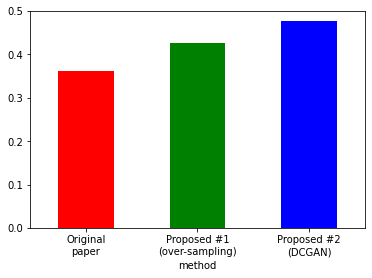

In [31]:
df = pd.DataFrame({'method':['Original\npaper', 'Proposed #1\n(over-sampling)', 'Proposed #2\n(DCGAN)'],
                   'accuracy':[perf1['accuracy'], perf10['accuracy'], perf11['accuracy']]})
ax = df.plot.bar(x='method', y='accuracy', color=['red', 'green', 'blue'], rot=0, legend=False)
